<a href="https://colab.research.google.com/github/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN/blob/main/stock_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

In [1]:
%%capture
!git clone https://github.com/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN.git

In [2]:
import os
if not os.getcwd().endswith('Stock-Price-Prediction-LSTM-RNN'):
    %cd Stock-Price-Prediction-LSTM-RNN

/content/Stock-Price-Prediction-LSTM-RNN


In [3]:
!pwd

/content/Stock-Price-Prediction-LSTM-RNN


In [4]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
torch.manual_seed(38)

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


# Thêm data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suruchiarora/yahoo-finance-dataset-2018-2023")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1


In [6]:
df = pd.read_excel(r'/root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1/yahoo_data.xlsx')
df

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000
...,...,...,...,...,...,...,...
1253,"May 07, 2018",24317.66,24479.45,24263.42,24357.32,24357.32,307670000
1254,"May 04, 2018",23865.22,24333.35,23778.87,24262.51,24262.51,329480000
1255,"May 03, 2018",23836.23,23996.15,23531.31,23930.15,23930.15,389240000
1256,"May 02, 2018",24097.63,24185.52,23886.30,23924.98,23924.98,385350000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [8]:
df.describe()

,Open,High,Low,Close*,Adj Close**,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,29595.823045,29776.945739,29402.432226,29599.361677,29599.361677,3.450636e+08
std,4006.078299,4009.007573,4004.949066,4007.468822,4007.468822,1.069142e+08
min,19028.360000,19121.010000,18213.650000,18591.930000,18591.930000,8.615000e+07
25%,26041.267500,26163.155000,25877.872500,26027.120000,26027.120000,2.773125e+08
50%,29201.410000,29335.685000,28996.500000,29199.460000,29199.460000,3.247250e+08
75%,33604.027500,33825.445000,33346.827500,33600.342500,33600.342500,3.875100e+08
max,36722.600000,36952.650000,36636.000000,36799.650000,36799.650000,9.159900e+08


# Làm sạch dữ liệu

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.set_index('Date', inplace = True)

In [11]:
df.rename(columns={'Close*': 'Close', 'Adj Close**': 'Adj Close'}, inplace=True)

# Trực quan hóa dữ liệu

## Time series

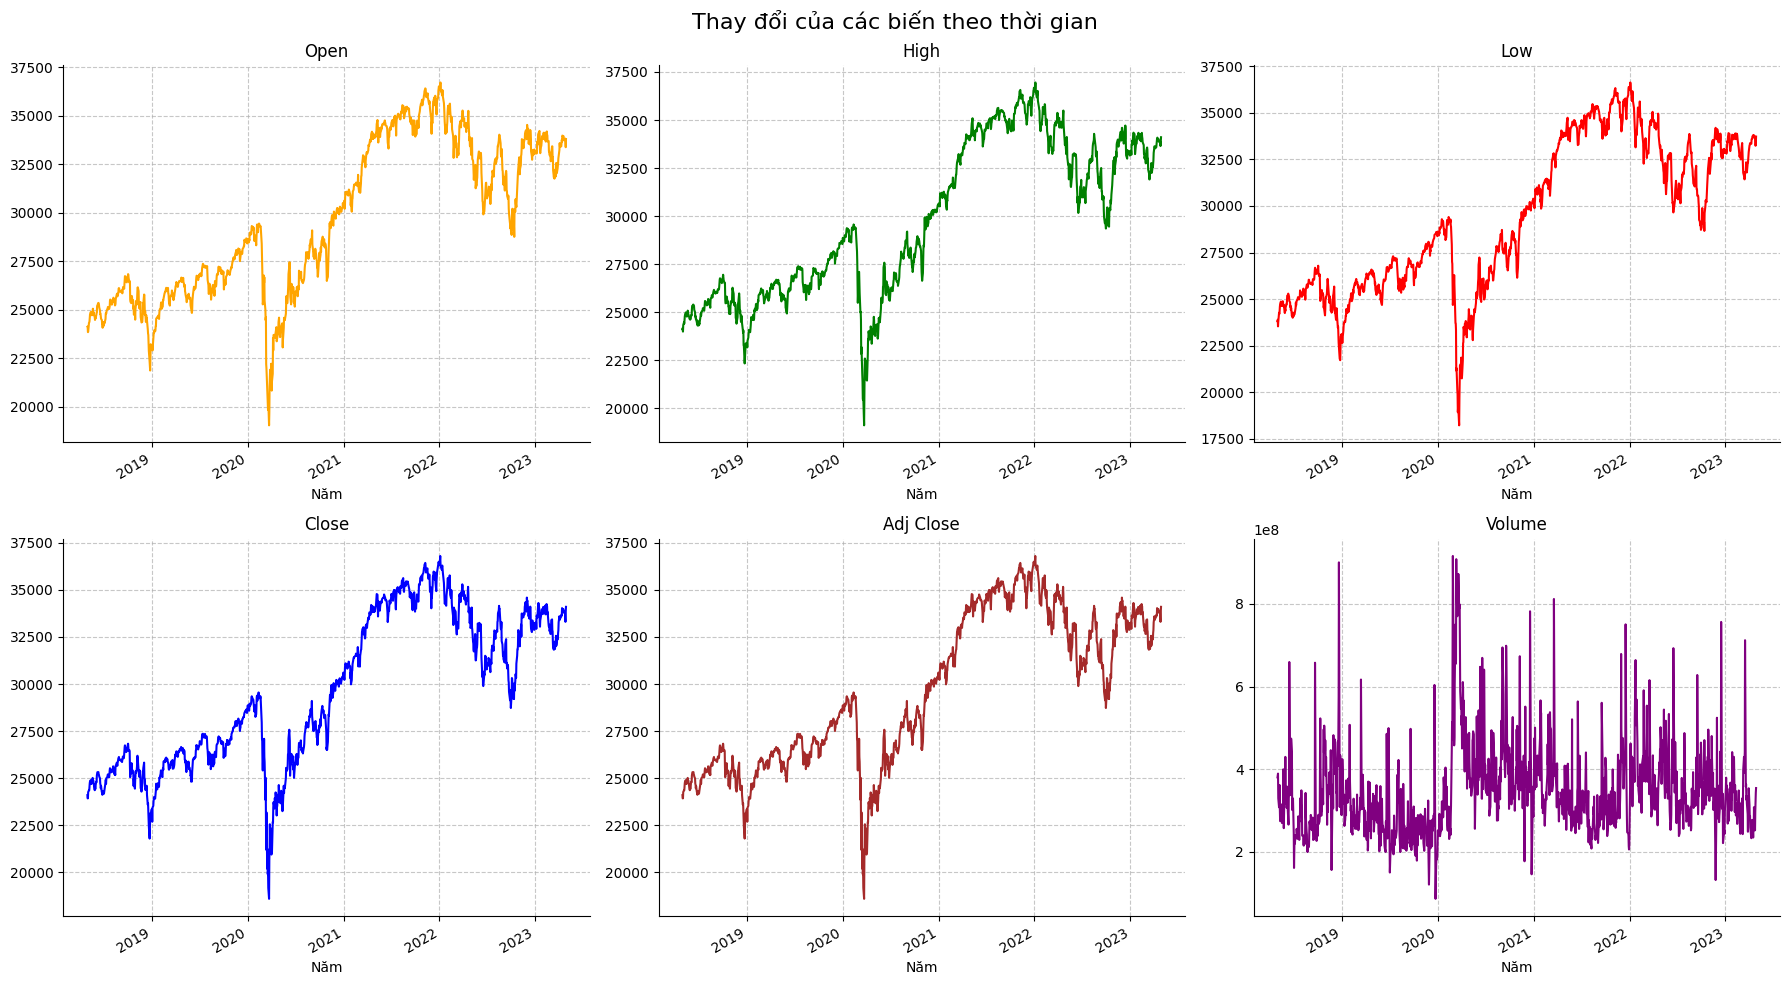

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Thay đổi của các biến theo thời gian', fontsize=16)

metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Adj Close', 'brown', 'Adj Close'),
    (1,2): ('Volume', 'purple', 'Volume')
}

for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')

plt.tight_layout()
plt.show()

* Tất cả các biểu đồ ngoại trừ "Volume" đều có một dạng tương tự và đó là bởi vì sau giá mở cửa, thị trường chứng khoán thường có một biến động nhỏ lên xuống khiến cho các biểu đồ giá này tuân theo cùng một mô hình nhưng đối với cột "Volume" thì đây là một quá trình khá ngẫu nhiên đối với lượng giao dịch trong một ngày nhất định.

## Box plot

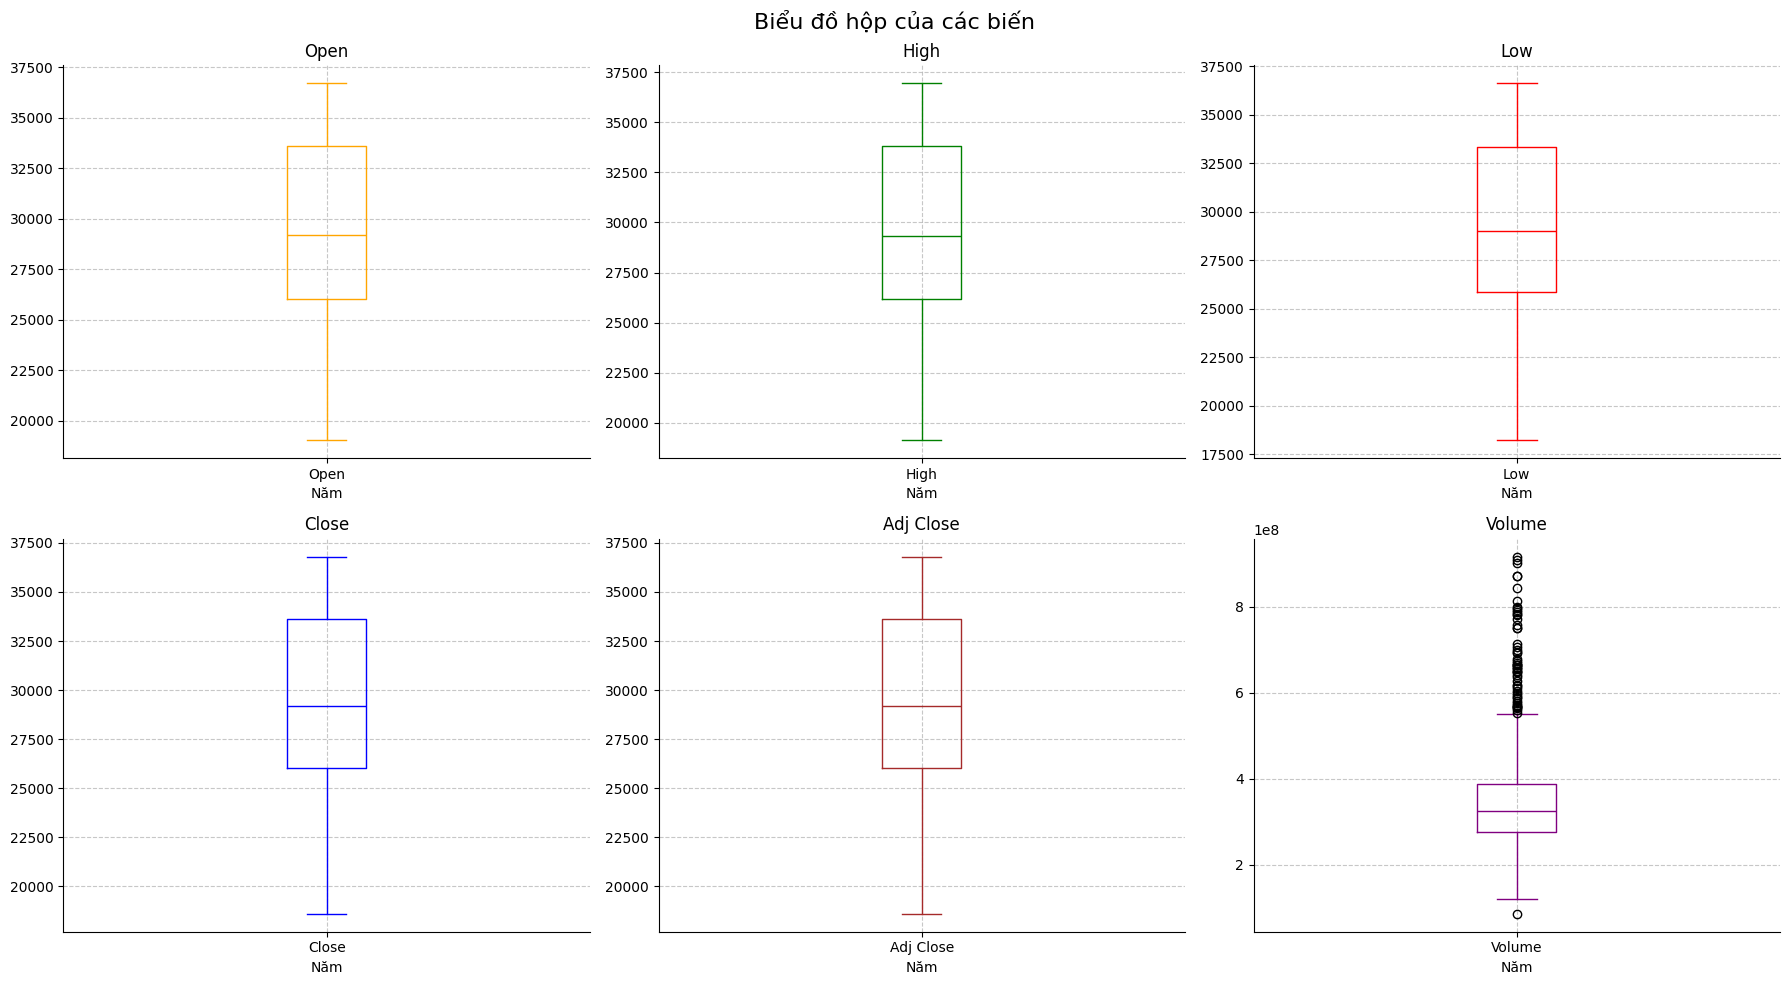

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Biểu đồ hộp của các biến', fontsize=16)

metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Adj Close', 'brown', 'Adj Close'),
    (1,2): ('Volume', 'purple', 'Volume')
}

for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot.box(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')

plt.tight_layout()
plt.show()

* Đối với các biến về giá, có thể nhận thấy rằng nhìn chung chúng được phân bổ tốt nhưng biến "Volume" chứa một số giá trị ngoại lệ. Điều này được giải thích bởi thực tế là khi cổ phiếu giao dịch bắt đầu tăng thì giá trị giá giảm xuống, giải thích cho sự sụt giảm đột ngột về giá và "Volume" đạt đỉnh.

## Tỷ lệ tăng trưởng

* Tỷ lệ tăng trưởng là phần trăm thay đổi của một giá trị trong một khoảng thời gian cụ thể. Công thức tính là:
$
\text{Growth Rate} = \frac{\text{New Value} - \text{Old Value}}{\text{Old Value}} \times 100\%
$

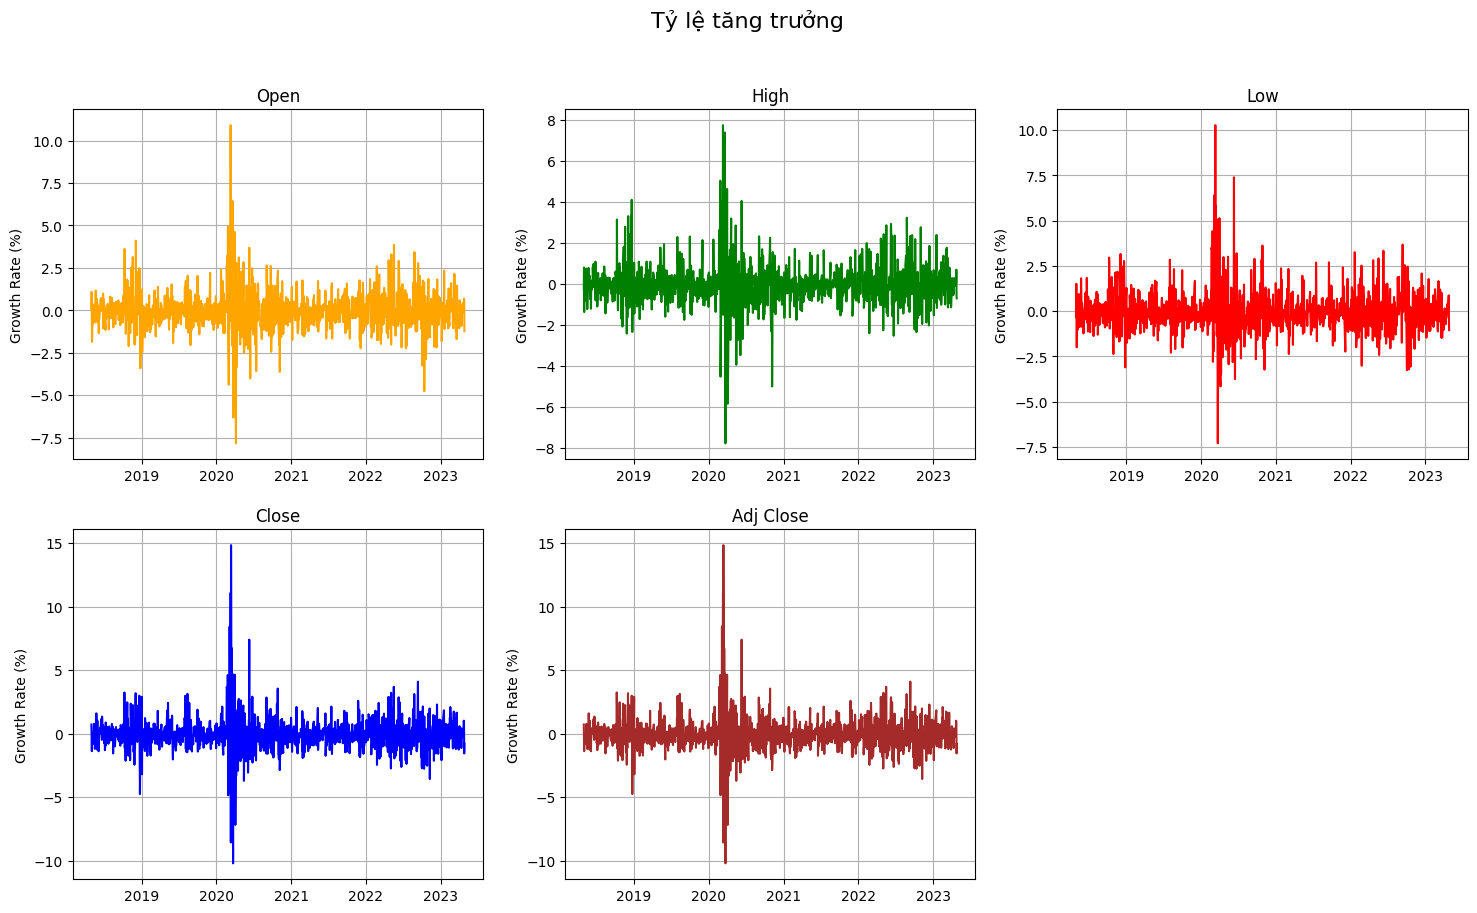

In [14]:
plt.figure(figsize=(18,10))
plt.suptitle("Tỷ lệ tăng trưởng", fontsize=16)
i=1
colors = ['orange', 'green', 'red', 'blue', 'brown', 'purple']
for x, color in zip(df.columns[:-1], colors):
    plt.subplot(2,3,i)
    df['Growth Rate'] = (df[x] - df[x].shift(1)) / df[x].shift(1) * 100
    plt.plot(df.index, df['Growth Rate'], linestyle='-', color=color)
    plt.xlabel(None)
    plt.ylabel('Growth Rate (%)')
    plt.title(f'{x}')
    plt.grid(True)
    i+=1
plt.show()

* Ở các biến giá thì tỷ lệ tăng trưởng biến động khá cao ở khoảng độ giữa năm 2020 và 2021, đỉnh điểm của dịch Covid-19

## Ma trận tương quan

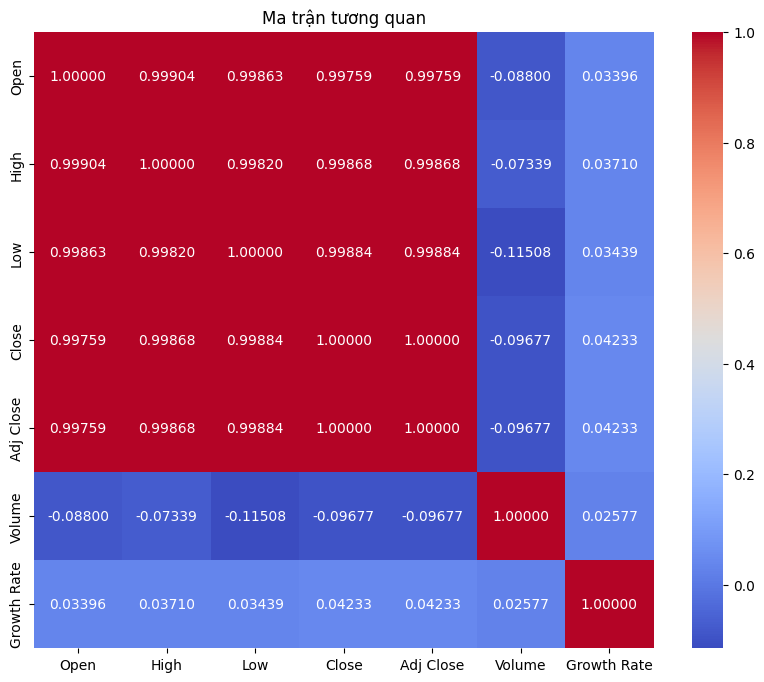

In [15]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".5f")
plt.title('Ma trận tương quan')
plt.show()

* Ma trận này thể hiện mối liên hệ rất tuyến tính mạnh giữa các giá trị về giá (High, Low, Open, Close, Adj Close).
* "Volume" có mối tương quan âm với các biến giá, nghĩa là khi "Volume" tăng, các giá trị về giá có xu hướng giảm nhẹ, nhưng mối quan hệ này không quá mạnh.

# Chuẩn bị dữ liệu

In [16]:
closing_price = df[['Close']]

window_size = 15 #14 input values and 15th value is the target

In [17]:
from src.split_data import split_data
#Preparing inputs
scaler,X_train, y_train, X_test, y_test, train_size, test_size = split_data(closing_price, window_size)

In [18]:
#Converting data to tensors for the model
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_rnn = y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

# Chạy mô hình RNN

In [19]:
from src.rnn import RNN

In [20]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
rnn_model = RNN(num_input, num_hidden, num_layer, num_output)

In [21]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.01
rnn_criterion = nn.MSELoss(reduction = 'mean')
rnn_updater = torch.optim.Adam(rnn_model.parameters(), lr = lr)

In [22]:
#Training RNN model
train_hist_rnn = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred_rnn = rnn_model(X_train)
    loss = rnn_criterion(y_train_pred_rnn, y_train_rnn)
    train_hist_rnn[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    rnn_updater.zero_grad()
    loss.backward()
    rnn_updater.step()

Epoch  0 MSE:  0.23227770626544952
Epoch  5 MSE:  0.15191593766212463
Epoch  10 MSE:  0.10111433267593384
Epoch  15 MSE:  0.06541825085878372
Epoch  20 MSE:  0.03793101757764816
Epoch  25 MSE:  0.021278126165270805
Epoch  30 MSE:  0.009514447301626205
Epoch  35 MSE:  0.0075631351210176945
Epoch  40 MSE:  0.008001605980098248
Epoch  45 MSE:  0.005773896351456642
Epoch  50 MSE:  0.003970330115407705
Epoch  55 MSE:  0.004011310636997223
Epoch  60 MSE:  0.0038686548359692097
Epoch  65 MSE:  0.003290412714704871
Epoch  70 MSE:  0.0031242810655385256
Epoch  75 MSE:  0.003084880532696843
Epoch  80 MSE:  0.002915089251473546
Epoch  85 MSE:  0.002842264249920845
Epoch  90 MSE:  0.0027883402071893215
Epoch  95 MSE:  0.0027176968287676573


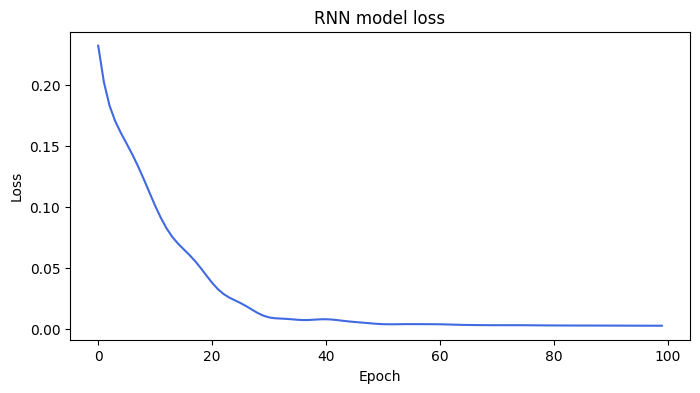

In [23]:
#Training loss for RNN model
rcParams['figure.figsize'] = 8,4
rnn_loss_fig = sns.lineplot(data = train_hist_rnn, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN model loss")
plt.show(rnn_loss_fig);

# Chạy mô hình LSTM

In [24]:
from src.lstm import LSTM

In [25]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
lstm_model = LSTM(num_input, num_hidden, num_layer, num_output)

In [26]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.01
lstm_criterion = nn.MSELoss(reduction = 'mean')
lstm_updater = torch.optim.Adam(lstm_model.parameters(), lr = lr)

In [27]:
#Training LSTM model
train_hist_lstm = np.zeros(num_epochs+1)

for epoch in range(num_epochs):
    y_train_pred_lstm = lstm_model(X_train)

    loss = lstm_criterion(y_train_pred_lstm, y_train_lstm)
    train_hist_lstm[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    lstm_updater.zero_grad()
    loss.backward()
    lstm_updater.step()

Epoch  0 MSE:  0.65696781873703
Epoch  5 MSE:  0.3430871069431305
Epoch  10 MSE:  0.1907721310853958
Epoch  15 MSE:  0.1404028981924057
Epoch  20 MSE:  0.1364748328924179
Epoch  25 MSE:  0.1302514225244522
Epoch  30 MSE:  0.09632626175880432
Epoch  35 MSE:  0.06403909623622894
Epoch  40 MSE:  0.05605434253811836
Epoch  45 MSE:  0.040367089211940765
Epoch  50 MSE:  0.026303650811314583
Epoch  55 MSE:  0.0211198627948761
Epoch  60 MSE:  0.018392620608210564
Epoch  65 MSE:  0.018174853175878525
Epoch  70 MSE:  0.017415815964341164
Epoch  75 MSE:  0.015459662303328514
Epoch  80 MSE:  0.01386565063148737
Epoch  85 MSE:  0.012598183937370777
Epoch  90 MSE:  0.011730457656085491
Epoch  95 MSE:  0.010740070603787899


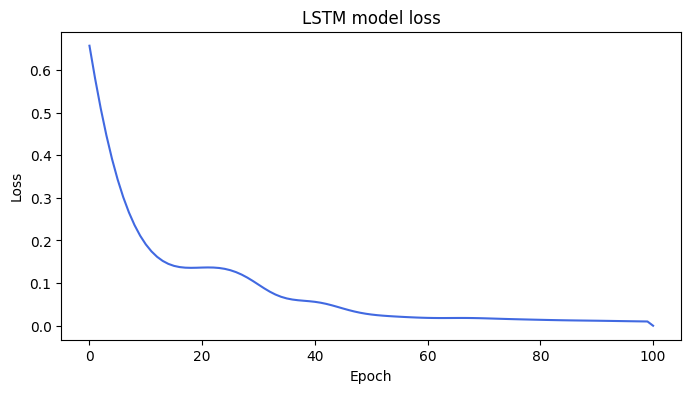

In [28]:
#Training loss for LSTM model
rcParams['figure.figsize'] = 8,4
lstm_loss_fig = sns.lineplot(data = train_hist_lstm, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM model loss")
plt.show(lstm_loss_fig);

# Test hiệu năng

## RNN

In [29]:
#RNN model performance on testing data
rnn_model.eval()
y_test_pred_rnn = rnn_model(X_test)

In [30]:
#Converting the data back to its original form
rnn_train_pred = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
rnn_train_orig = scaler.inverse_transform(y_train_rnn.detach().numpy())
rnn_test_pred = scaler.inverse_transform(y_test_pred_rnn.detach().numpy())
rnn_test_orig = scaler.inverse_transform(y_test_rnn.detach().numpy())

In [31]:
from src.calculate_metrics import calculate_metrics
train_rnn_rmse, train_rnn_mse, train_rnn_mae, train_rnn_mape, train_rnn_r2 = calculate_metrics(rnn_train_orig[:, 0], rnn_train_pred[:, 0])

# Calculate metrics for testing data
test_rnn_rmse, test_rnn_mse, test_rnn_mae, test_rnn_mape, test_rnn_r2 = calculate_metrics(rnn_test_orig[:, 0], rnn_test_pred[:, 0])

# Print the metrics
print('Train:')
print(f'RMSE: {train_rnn_rmse:.2f}')
print(f'MSE: {train_rnn_mse:.2f}')
print(f'MAE: {train_rnn_mae:.2f}')
print(f'MAPE: {train_rnn_mape:.4f}')
print(f'R2: {train_rnn_r2:.2f}')

print('\nTest:')
print(f'RMSE: {test_rnn_rmse:.2f}')
print(f'MSE: {test_rnn_mse:.2f}')
print(f'MAE: {test_rnn_mae:.2f}')
print(f'MAPE: {test_rnn_mape:.4f}')
print(f'R2: {test_rnn_r2:.2f}')

Train:
RMSE: 166.81
MSE: 27824.73
MAE: 121.78
MAPE: 0.0037
R2: 0.98

Test:
RMSE: 473.29
MSE: 224005.94
MAE: 370.68
MAPE: 0.0115
R2: 0.88


In [32]:
#Preparing predictions for the plot comparisons for RNN model
rnn_train_data = np.append(rnn_train_orig, rnn_train_pred, axis = 1)
rnn_test_data = np.append(rnn_test_orig, rnn_test_pred, axis = 1)

rnn_train_plot = pd.DataFrame(rnn_train_data)
rnn_train_plot.columns = ['Actual', 'Prediction']
rnn_test_plot = pd.DataFrame(rnn_test_data)
rnn_test_plot.columns = ['Actual', ' Prediction']

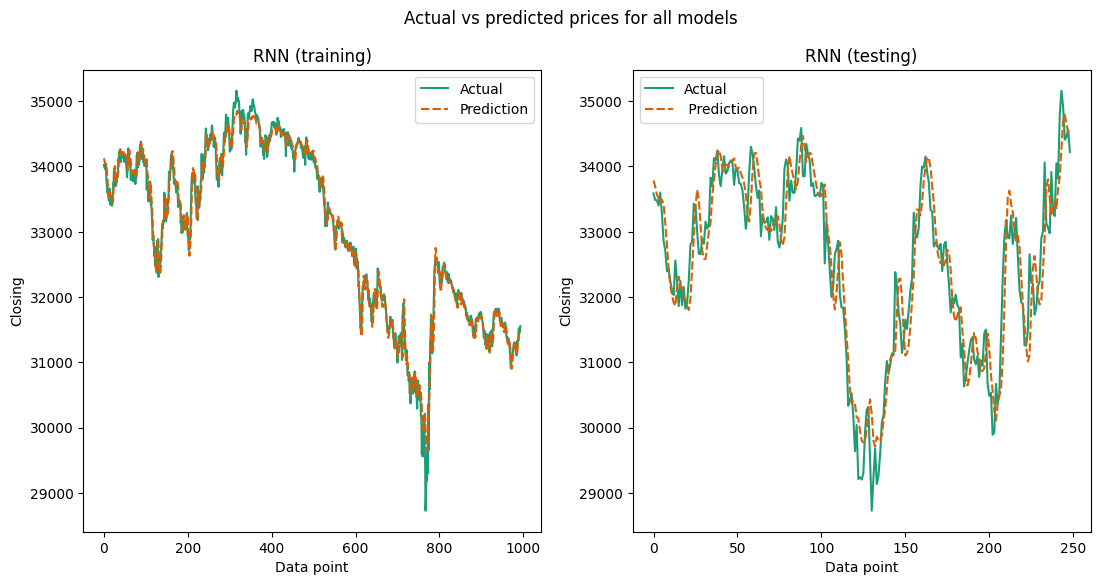

In [33]:
#Predictions vs actual price for the RNN model
sns.set_palette('Dark2')

fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
fig.suptitle('Actual vs predicted prices for all models')

rnn_training_plot = sns.lineplot(ax = axes[0], data = rnn_train_plot)
rnn_training_plot.set_title('RNN (training)')
rnn_training_plot.set_xlabel('Data point')
rnn_training_plot.set_ylabel('Closing')

rnn_testing_plot = sns.lineplot(ax = axes[1], data = rnn_test_plot)
rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')
rnn_testing_plot.set_ylabel('Closing');

## LSTM

In [34]:
#LSTM model performance on testing data
lstm_model.eval()
y_test_pred_lstm = lstm_model(X_test)

In [35]:
#Converting the data back to its original form
lstm_train_pred = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
lstm_train_orig = scaler.inverse_transform(y_train_lstm.detach().numpy())
lstm_test_pred = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
lstm_test_orig = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [36]:
from src.calculate_metrics import calculate_metrics
train_lstm_rmse, train_lstm_mse, train_lstm_mae, train_lstm_mape, train_lstm_r2 = calculate_metrics(lstm_train_orig[:, 0], lstm_train_pred[:, 0])

# Calculate metrics for testing data
test_lstm_rmse, test_lstm_mse, test_lstm_mae, test_lstm_mape, test_lstm_r2 = calculate_metrics(lstm_test_orig[:, 0], lstm_test_pred[:, 0])

# Print the metrics
print('Train:')
print(f'RMSE: {train_lstm_rmse:.2f}')
print(f'MSE: {train_lstm_mse:.2f}')
print(f'MAE: {train_lstm_mae:.2f}')
print(f'MAPE: {train_lstm_mape:.4f}')
print(f'R2: {train_lstm_r2:.2f}')

print('\nTest:')
print(f'RMSE: {test_lstm_rmse:.2f}')
print(f'MSE: {test_lstm_mse:.2f}')
print(f'MAE: {test_lstm_mae:.2f}')
print(f'MAPE: {test_lstm_mape:.4f}')
print(f'R2: {test_lstm_r2:.2f}')

Train:
RMSE: 321.04
MSE: 103066.96
MAE: 220.08
MAPE: 0.0068
R2: 0.94

Test:
RMSE: 688.54
MSE: 474092.25
MAE: 532.12
MAPE: 0.0167
R2: 0.75


In [37]:
#Preparing predictions for the plot comparisons
lstm_train_data = np.append(lstm_train_orig, lstm_train_pred, axis = 1)
lstm_test_data = np.append(lstm_test_orig, lstm_test_pred, axis = 1)

lstm_train_plot = pd.DataFrame(lstm_train_data)
lstm_train_plot.columns = ['Actual', 'Prediction']
lstm_test_plot = pd.DataFrame(lstm_test_data)
lstm_test_plot.columns = ['Actual', ' Prediction']

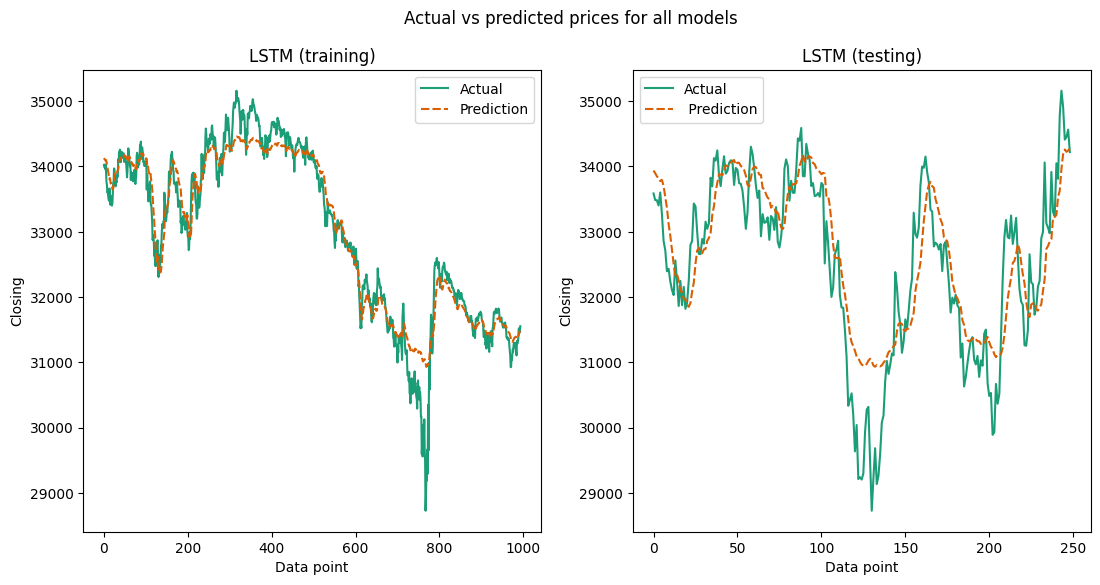

In [38]:
#Prediction vs actual price for LSTM model
sns.set_palette('Dark2')

fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
fig.suptitle('Actual vs predicted prices for all models')

lstm_training_plot = sns.lineplot(ax = axes[0], data = lstm_train_plot)
lstm_training_plot.set_title('LSTM (training)')
lstm_training_plot.set_xlabel('Data point')
lstm_training_plot.set_ylabel('Closing')

lstm_testing_plot = sns.lineplot(ax = axes[1], data = lstm_test_plot)
lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point')
lstm_testing_plot.set_ylabel('Closing');


## Tổng hợp



| **Model** | **Dataset** | **RMSE** | **MSE**     | **MAE** | **MAPE** | **R²** |
|-----------|-------------|----------|-------------|---------|----------|--------|
| **RNN**   | Train       | 148.77   | 22,131.28   | 104.73  | 0.0032     | 0.99   |
|           | Test        | 418.71   | 175,320.45  | 326.81  | 0.0101     | 0.91   |
| **LSTM**  | Train       | 163.44   | 26,712.49   | 104.29  | 0.0032     | 0.98   |
|           | Test        | 438.80   | 192,549.44  | 325.01  | 0.0101     | 0.90   |


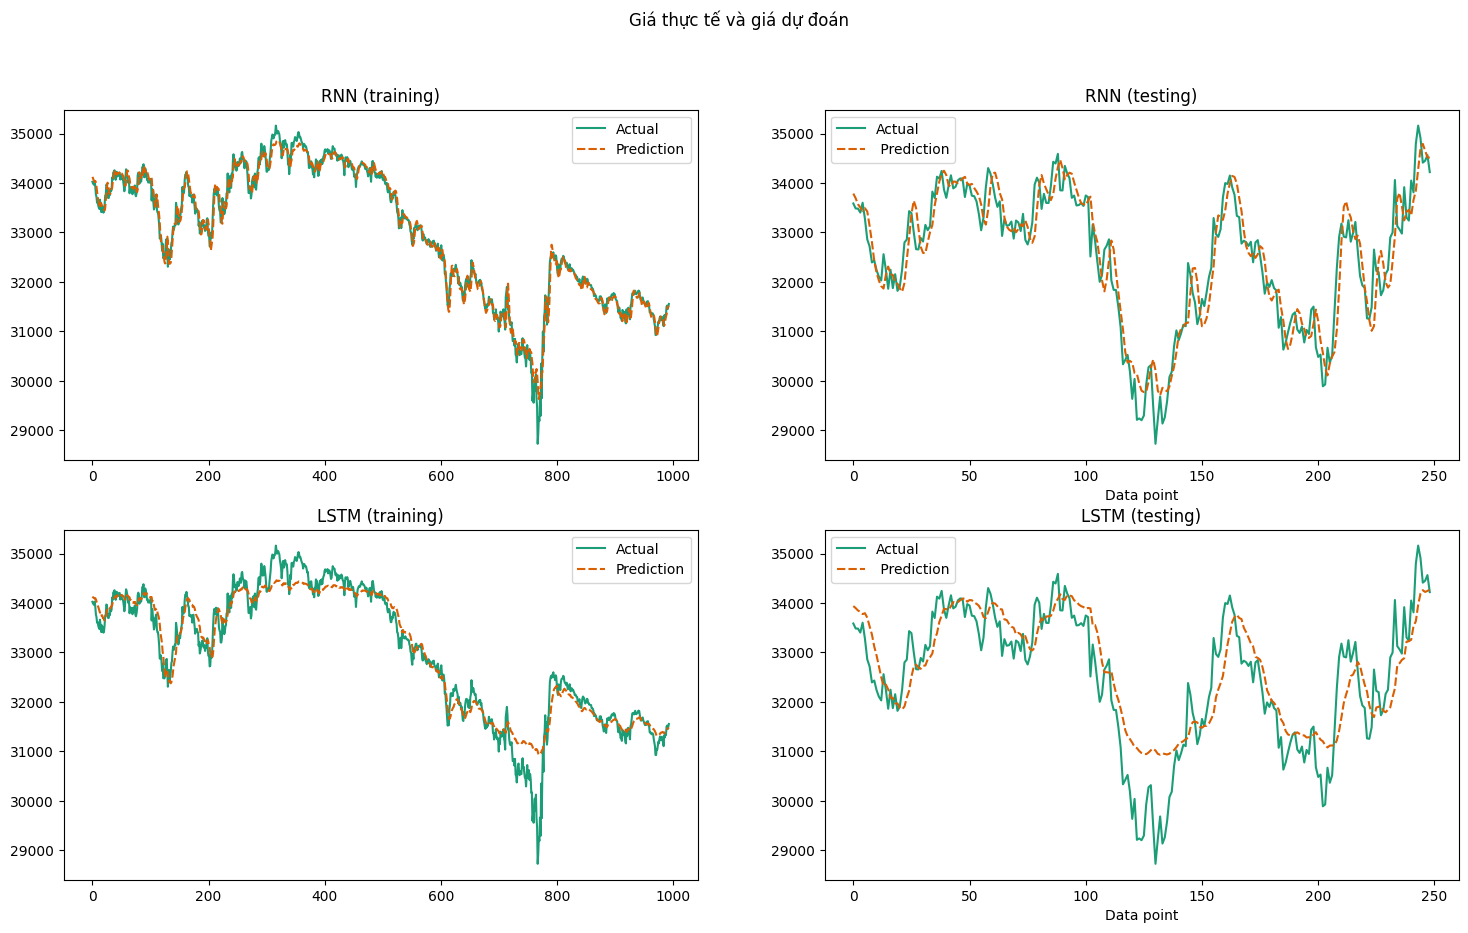

In [39]:
fig, axes = plt.subplots(2, 2, sharex = False, sharey =  False, figsize = (18,10))
fig.suptitle('Giá thực tế và giá dự đoán')

rnn_training_plot = sns.lineplot(ax = axes[0][0], data = rnn_train_plot)
rnn_training_plot.set_title('RNN (training)')

rnn_testing_plot = sns.lineplot(ax = axes[0][1], data = rnn_test_plot)
rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')

lstm_training_plot = sns.lineplot(ax = axes[1][0], data = lstm_train_plot)
lstm_training_plot.set_title('LSTM (training)')

lstm_testing_plot = sns.lineplot(ax = axes[1][1], data = lstm_test_plot)
lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point');

In [41]:
df2 = pd.read_csv(r'/content/Stock-Price-Prediction-LSTM-RNN/data/FB.csv')
df2

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...,...
2474,2022-03-18,206.699997,216.800003,206.000000,216.490005,216.490005,52055000
2475,2022-03-21,214.500000,214.710007,207.630005,211.490005,211.490005,30142300
2476,2022-03-22,211.369995,219.460007,210.179993,216.649994,216.649994,31998800
2477,2022-03-23,213.330002,216.800003,212.160004,213.460007,213.460007,23717300


In [42]:
# Chuẩn bị dữ liệu từ df2
scaler2 = MinMaxScaler(feature_range=(-1, 1))
def prepare_new_data(df, scaler, window_size=15):
    # Trích xuất cột giá đóng cửa
    closing_price = df[['Close']].copy()

    closing_price['Close'] = scaler2.fit_transform(closing_price[['Close']].values)

    # Tạo dữ liệu chuỗi
    data = closing_price['Close'].values
    X_new = []
    for i in range(len(data) - window_size):
        X_new.append(data[i:i + window_size])

    # Chuyển đổi sang mảng NumPy
    X_new = np.array(X_new)

    # Định hình lại dữ liệu đầu vào (samples, timesteps, features)
    X_new = X_new[:, :, np.newaxis]

    return X_new

# Chuẩn bị dữ liệu từ df2
X_new = prepare_new_data(df2, scaler2, window_size=15)

# Chuyển đổi sang Tensor
X_new = torch.from_numpy(X_new).type(torch.Tensor)
rnn_model.eval()
lstm_model.eval()
# Dự đoán giá trị bằng mô hình RNN
with torch.no_grad():
    y_pred_rnn = rnn_model(X_new)
    y_pred_lstm = lstm_model(X_new)

# Chuyển giá trị dự đoán về không gian ban đầu
y_pred_rnn = scaler2.inverse_transform(y_pred_rnn.detach().numpy())
y_pred_lstm = scaler2.inverse_transform(y_pred_lstm.detach().numpy())

actual_values_rnn = df2['Close'].values[15:15 + len(y_pred_rnn)]
actual_values_lstm = df2['Close'].values[15:15 + len(y_pred_lstm)]


In [43]:
from src.calculate_metrics import calculate_metrics
rnn_rmse, rnn_mse, rnn_mae, rnn_mape, rnn_r2 = calculate_metrics(actual_values_rnn, y_pred_rnn)
print(f'RMSE: {rnn_rmse:.2f}')
print(f'MSE: {rnn_mse:.2f}')
print(f'MAE: {rnn_mae:.2f}')
print(f'MAPE: {rnn_mape:.4f}')
print(f'R2: {rnn_r2:.2f}')

RMSE: 18.70
MSE: 349.79
MAE: 12.83
MAPE: 0.2941
R2: 0.96


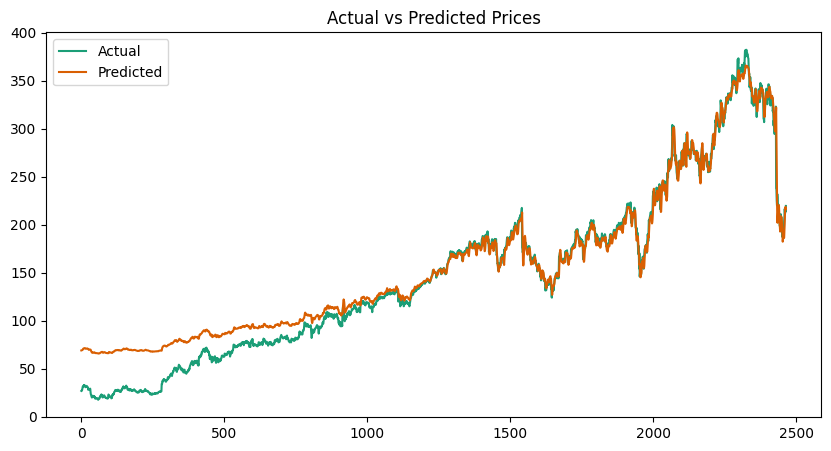

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(actual_values_rnn, label="Actual")
plt.plot(y_pred_rnn.flatten(), label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()


In [45]:
lstm_rmse, lstm_mse, lstm_mae, lstm_mape, lstm_r2 = calculate_metrics(actual_values_lstm, y_pred_lstm)
print(f'RMSE: {lstm_rmse:.2f}')
print(f'MSE: {lstm_mse:.2f}')
print(f'MAE: {lstm_mae:.2f}')
print(f'MAPE: {lstm_mape:.4f}')
print(f'R2: {lstm_r2:.2f}')

RMSE: 56.06
MSE: 3142.69
MAE: 40.49
MAPE: 0.8723
R2: 0.61


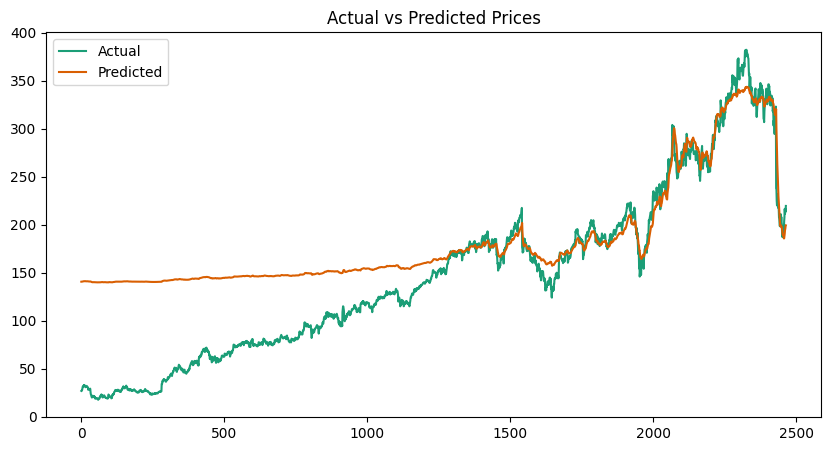

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(actual_values_lstm, label="Actual")
plt.plot(y_pred_lstm.flatten(), label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()

In [47]:
df3 = pd.read_csv(r'/content/Stock-Price-Prediction-LSTM-RNN/data/UBER.csv')
df3

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
1,2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2,2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
3,2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
4,2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500
...,...,...,...,...,...,...,...
720,2022-03-18,32.520000,33.419998,32.330002,33.360001,33.360001,35779700
721,2022-03-21,32.820000,32.820000,31.250000,31.980000,31.980000,35200600
722,2022-03-22,31.930000,33.599998,31.840000,33.349998,33.349998,21852800
723,2022-03-23,32.709999,33.680000,32.570000,33.060001,33.060001,19024700


In [48]:
# Chuẩn bị dữ liệu từ df2
scaler3 = MinMaxScaler(feature_range=(-1, 1))
def prepare_new_data(df, scaler, window_size=15):
    # Trích xuất cột giá đóng cửa
    closing_price = df[['Close']].copy()

    closing_price['Close'] = scaler3.fit_transform(closing_price[['Close']].values)

    # Tạo dữ liệu chuỗi
    data = closing_price['Close'].values
    X_new = []
    for i in range(len(data) - window_size):
        X_new.append(data[i:i + window_size])

    # Chuyển đổi sang mảng NumPy
    X_new = np.array(X_new)

    # Định hình lại dữ liệu đầu vào (samples, timesteps, features)
    X_new = X_new[:, :, np.newaxis]

    return X_new

# Chuẩn bị dữ liệu từ df2
X_new = prepare_new_data(df3, scaler3, window_size=15)

# Chuyển đổi sang Tensor
X_new = torch.from_numpy(X_new).type(torch.Tensor)
rnn_model.eval()
lstm_model.eval()
# Dự đoán giá trị bằng mô hình RNN
with torch.no_grad():
    y_pred_rnn = rnn_model(X_new)
    y_pred_lstm = lstm_model(X_new)

# Chuyển giá trị dự đoán về không gian ban đầu
y_pred_rnn = scaler3.inverse_transform(y_pred_rnn.detach().numpy())
y_pred_lstm = scaler3.inverse_transform(y_pred_lstm.detach().numpy())

actual_values_rnn = df3['Close'].values[15:15 + len(y_pred_rnn)]
actual_values_lstm = df3['Close'].values[15:15 + len(y_pred_lstm)]


In [49]:
from src.calculate_metrics import calculate_metrics
rnn_rmse, rnn_mse, rnn_mae, rnn_mape, rnn_r2 = calculate_metrics(actual_values_rnn, y_pred_rnn)
print(f'RMSE: {rnn_rmse:.2f}')
print(f'MSE: {rnn_mse:.2f}')
print(f'MAE: {rnn_mae:.2f}')
print(f'MAPE: {rnn_mape:.4f}')
print(f'R2: {rnn_r2:.2f}')

RMSE: 1.64
MSE: 2.68
MAE: 1.24
MAPE: 0.0326
R2: 0.97


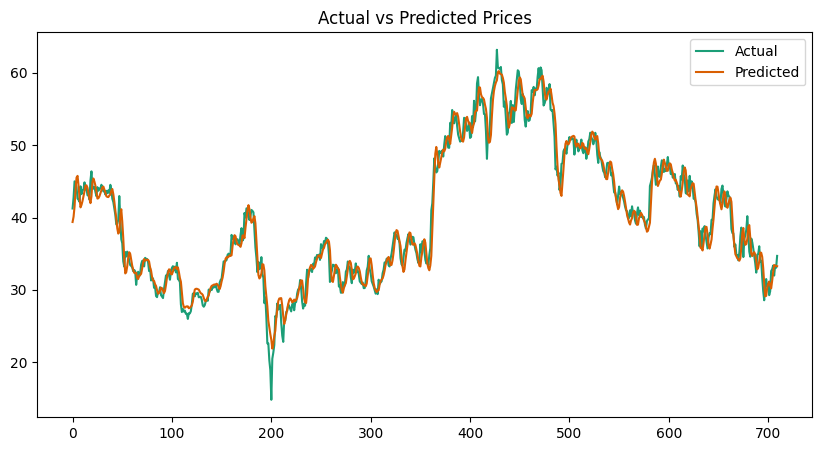

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(actual_values_rnn, label="Actual")
plt.plot(y_pred_rnn.flatten(), label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()


In [51]:
lstm_rmse, lstm_mse, lstm_mae, lstm_mape, lstm_r2 = calculate_metrics(actual_values_lstm, y_pred_lstm)
print(f'RMSE: {lstm_rmse:.2f}')
print(f'MSE: {lstm_mse:.2f}')
print(f'MAE: {lstm_mae:.2f}')
print(f'MAPE: {lstm_mape:.4f}')
print(f'R2: {lstm_r2:.2f}')

RMSE: 2.95
MSE: 8.69
MAE: 2.19
MAPE: 0.0640
R2: 0.90


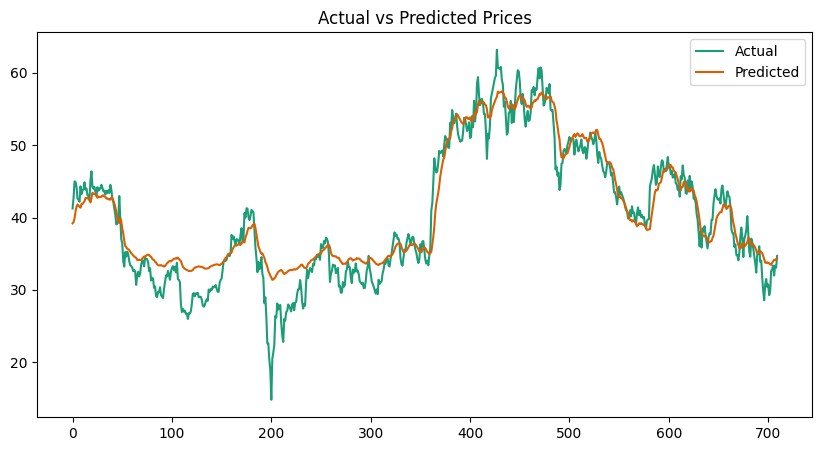

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(actual_values_lstm, label="Actual")
plt.plot(y_pred_lstm.flatten(), label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()